# Google 'Image Box' analysis

**First import all the libraries we want, together with some formatting options**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Read in Google Scraper search results table 

In [ ]:
cols = ['requested_at', 'search_query', 'visible_link', 'rank' ,'image_path']

In [ ]:
data = pd.read_csv('./image_box_data.csv', parse_dates=['requested_at'], usecols=cols)
data.head()

In [ ]:
type(data.requested_at[0])

## Programatically identify unique images 
* Read in each image, calculate a unique hash based on the image data, a bit like a fingerprint, and store the hash along with the image filename in a shelf (a persistent dictionary). Many images were repeats, so there were many image filenames stored with the same hash key. 

* The code is based on this blog post: https://realpython.com/blog/python/fingerprinting-images-for-near-duplicate-detection/ which I adapted to work with Python3

In [ ]:
# Check the shelf has content. If nothing is printed out, run the following two scripts/cells
import shelve
db = shelve.open('db.shelve')
for k in db.keys():
    print(k)
db.close()

In [ ]:
%run ../index.py --dataset ./clinton --shelve db.shelve

In [ ]:
%run ../index.py --dataset ./trump --shelve db.shelve

### Add the hash to each row in our `data` dataframe we loaded above

In [ ]:
import shelve

db = shelve.open('db.shelve')

for key in db.keys():   #  For every hash KEY
    for f in db[key]:   # for every file path name ITEM within the KEY
        for index, i in enumerate(data.image_path):      # For every Image path in each row of my DF
            if f in i:                                   # If the ITEM file path is also in the IMAGE PATH of my DF
                data.loc[index, 'image_hash'] = key      # Put the KEY into the 'image_hash' Column

data.to_csv("./hashedDF.csv", index=False)

db.close()

# Open new dataframe with image hashes

In [2]:
hashedDF = pd.read_csv('./hashedDF.csv')
hashedDF.head()

,requested_at,search_query,visible_link,rank,image_path,image_hash
0,2016-09-03 17:21:43,hillary clinton,https://plus.google.com/100418579567144177985,1,./images/4352/4352_1_hillary_clinton_1.jpg,861e1f37179f0e8c
1,2016-09-03 17:21:43,hillary clinton,https://en.wikipedia.org/wiki/Hillary_Clinton,2,./images/4352/4352_2_hillary_clinton_2.jpg,764fce5e4be6b6d2
2,2016-09-03 17:21:43,hillary clinton,http://russia-insider.com/en/node/15518,3,./images/4352/4352_3_hillary_clinton_3.jpg,2f1e0e0e1f1b1b9b
3,2016-09-03 17:21:43,hillary clinton,http://www.cnn.com/election/primaries/candidat...,4,./images/4352/4352_4_hillary_clinton_4.jpg,96970f0706064e86
4,2016-09-03 17:21:43,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4352/4352_5_hillary_clinton_5.jpg,983d7d1c3c1c1c6f


In [3]:
hashedDF['requested_at'] = pd.to_datetime(hashedDF['requested_at'])

In [4]:
type(hashedDF.requested_at[0])

pandas.tslib.Timestamp

In [5]:
len(hashedDF)

645

___
# HILLARY CLINTON DATA

In [87]:
HC = hashedDF[hashedDF.search_query == 'hillary clinton']
HC.to_csv('HC_hashed.csv', index=False)

In [88]:
HC = pd.read_csv('HC_hashed.csv')

In [ ]:
# What are the news sources, and how many times do they appear in the dataset?
HC.visible_link.value_counts()

In [ ]:
# What are the hashes, and how many times does each one appear in the dataset?
HC.image_hash.value_counts()

In [ ]:
print(len(HC.visible_link.unique()))
print(len(HC.image_hash.unique()))

In [ ]:
HC.head()

In [ ]:
print(type(HC.image_hash[0]))
print(type(HC['rank'][0]))
print(type(HC.requested_at[0]))

##  Find an image file representative of each unique hash so we can look at each unique image

In [ ]:
HC_unique_images = HC.groupby('image_hash').first().reset_index()
HC_unique_images

## Collect unique images and put in separate directory

In [ ]:
from shutil import copyfile
import os

In [ ]:
def select_images(df_series, src_dir, dest_dir):
    '''
    provide dataframe series with all the image file names, the directory containing the images, and directory 
    where the unique images should go.
    '''
    try:
        os.mkdir(dest_dir)
        for file in df_series:
            file = file.split('/')[-1] 
            copyfile(src_dir + file, dest_dir + file)
        
    except FileExistsError:
        pass

In [ ]:
select_images(HC_unique_images.image_path,'clinton/', 'clinton_unique/' )

___
# DONALD TRUMP DATA

In [90]:
DT = hashedDF[hashedDF.search_query == 'donald trump']
DT.to_csv('DT_hashed.csv', index=False)
DT = pd.read_csv('DT_hashed.csv')

In [91]:
DT.visible_link.value_counts()

https://plus.google.com/104922825144470163120                                                                                57
https://www.theodysseyonline.com/examples-of-donald-trumps-douchebaggery                                                     51
http://www.slate.com/blogs/the_slatest/2016/02/27/donald_trump_vows_to_curb_press_freedom_through_libel_laws.html            45
http://www.slate.com/blogs/moneybox/2015/08/16/donald_trump_on_immigration_build_border_fence_make_mexico_pay_for_it.html    35
http://www.businessinsider.com/donald-trump-polls-leads-florida-michigan-ohio-2016-3                                         34
https://en.wikipedia.org/wiki/Donald_Trump                                                                                   23
http://www.snopes.com/2016/06/23/donald-trump-rape-lawsuit/                                                                  15
http://www.businessinsider.com/celebrities-who-support-trump-2016-10                                    

In [ ]:
DT.image_hash.value_counts()

## Find an image file representative of each unique hash.

In [ ]:
DT_unique_images = DT.groupby('image_hash').first().reset_index()
DT_unique_images

## Collect unique images and put in separate directory

In [ ]:
select_images(DT_unique_images.image_path,'trump/', 'trump_unique/' )

________
# NEWS SOURCE INFORMATION

In [92]:
HC.visible_link.describe()

count                                               337
unique                                               11
top       https://en.wikipedia.org/wiki/Hillary_Clinton
freq                                                 57
Name: visible_link, dtype: object

In [93]:
DT.visible_link.describe()

count                                               308
unique                                               17
top       https://plus.google.com/104922825144470163120
freq                                                 57
Name: visible_link, dtype: object

## Getting Political Leaning from [Allsides](https://www.allsides.com) from News Sources of all images in basline dataset

![allsides](../logo-all-sides-medium.png) 
Allsides bias data was generously provided by [Allsides](https://www.allsides.com) 



In [94]:
allsides = pd.read_json('../BASELINE/allsides_data.json')
allsides.head()

,allsides_url,bias_rating,news_source,url
0,http://www.allsides.com/node/20678,71,Bruce Braley,http://www.brucebraley.com
1,http://www.allsides.com/node/28762,71,Tallahassee Democrat,http://www.tallahassee.com/
2,http://www.allsides.com/node/20582,71,Mark Udall,http://markudall.com/
3,http://www.allsides.com/node/28766,71,Care 2,http://www.care2.com
4,http://www.allsides.com/node/33340,71,Herald Democrat,http://heralddemocrat.com/


In [95]:
HC_unique_news_sources = []

In [96]:
HC.visible_link.unique()

array(['https://plus.google.com/100418579567144177985',
       'https://en.wikipedia.org/wiki/Hillary_Clinton',
       'http://russia-insider.com/en/node/15518',
       'http://www.cnn.com/election/primaries/candidates/hillary-clinton',
       'https://www.youtube.com/watch?v=-dY77j6uBHI',
       'http://www.biography.com/people/hillary-clinton-9251306',
       'http://time.com/3882496/hillary-clinton-liberal-issues-mainstream-polling/',
       'https://mises.org/blog/hillary-clinton-wins-federal-reserve-primary',
       'http://www.politico.com/story/2016/01/clinton-obama-supreme-court-218259',
       'http://www.politicususa.com/2016/10/02/texas-newspaper-destroys-myth-hillary-clinton-lesser-evils.html',
       'http://www.businessinsider.com/hillary-clinton-donald-trump-helps-her-2015-9'], dtype=object)

In [97]:
HC[HC.visible_link.isnull()]

,requested_at,search_query,visible_link,rank,image_path,image_hash


In [98]:
def get_unique_news_sources(col, source_list):
    print(len(col.unique()))
    for i in col.unique():
        print(i)
        source_list.append(i.split('//')[1].split('/')[0])

In [99]:
get_unique_news_sources(HC.visible_link, HC_unique_news_sources)

11
https://plus.google.com/100418579567144177985
https://en.wikipedia.org/wiki/Hillary_Clinton
http://russia-insider.com/en/node/15518
http://www.cnn.com/election/primaries/candidates/hillary-clinton
https://www.youtube.com/watch?v=-dY77j6uBHI
http://www.biography.com/people/hillary-clinton-9251306
http://time.com/3882496/hillary-clinton-liberal-issues-mainstream-polling/
https://mises.org/blog/hillary-clinton-wins-federal-reserve-primary
http://www.politico.com/story/2016/01/clinton-obama-supreme-court-218259
http://www.politicususa.com/2016/10/02/texas-newspaper-destroys-myth-hillary-clinton-lesser-evils.html
http://www.businessinsider.com/hillary-clinton-donald-trump-helps-her-2015-9


In [100]:
HC_unique_news_sources

['plus.google.com',
 'en.wikipedia.org',
 'russia-insider.com',
 'www.cnn.com',
 'www.youtube.com',
 'www.biography.com',
 'time.com',
 'mises.org',
 'www.politico.com',
 'www.politicususa.com',
 'www.businessinsider.com']

In [101]:
DT_unique_news_sources = []
get_unique_news_sources(DT.visible_link, DT_unique_news_sources)

17
https://plus.google.com/104922825144470163120
https://en.wikipedia.org/wiki/Donald_Trump
http://www.businessinsider.com/donald-trump-polls-leads-florida-michigan-ohio-2016-3
http://www.snopes.com/2016/06/23/donald-trump-rape-lawsuit/
https://www.theodysseyonline.com/examples-of-donald-trumps-douchebaggery
http://www.slate.com/blogs/the_slatest/2016/02/27/donald_trump_vows_to_curb_press_freedom_through_libel_laws.html
http://www.cnn.com/2016/04/18/politics/new-york-city-donald-trump/
http://wonkette.com/605010/donald-trump-so-mad-colorado-fire-marshal-refused-to-let-him-die-in-a-fire
http://wonkette.com/606292/donald-trump-thinks-hillary-clinton-just-doesnt-have-that-presidential-look
http://wonkette.com/tag/donald-trump
http://www.slate.com/blogs/moneybox/2015/08/16/donald_trump_on_immigration_build_border_fence_make_mexico_pay_for_it.html
http://www.nationalreview.com/article/431420/donald-trumps-2016-debate-lies-he-went-bankrupt
http://www.businessinsider.com/donald-trump-celebrit

In [102]:
DT_unique_news_sources

['plus.google.com',
 'en.wikipedia.org',
 'www.businessinsider.com',
 'www.snopes.com',
 'www.theodysseyonline.com',
 'www.slate.com',
 'www.cnn.com',
 'wonkette.com',
 'wonkette.com',
 'wonkette.com',
 'www.slate.com',
 'www.nationalreview.com',
 'www.businessinsider.com',
 'www.headlinepolitics.com',
 'www.reddit.com',
 'www.businessinsider.com',
 'www.businessinsider.com']

In [103]:
def get_url(col):
    col = col.split('//')[1]
    col = col.split('/')[0]
    return col

In [104]:
HC.loc[:, 'news_source_url'] = HC.visible_link.apply(get_url)
DT.loc[:, 'news_source_url'] = DT.visible_link.apply(get_url)

In [107]:
def tag_bias_rating(candidate):
    
    candidate.loc['bias_rating'] = 999
    allsides = pd.read_json('../BASELINE/allsides_data.json')

    for i, valuei in enumerate(candidate.news_source_url):
        for j, valuej in enumerate(allsides.url):
            
            print(valuei, valuej)
            
            if 'http' in valuej:
                print(valuej)
                valuej = valuej.split('//')[1]
                print(valuej)
        
#             if valuei in valuej:          
#                 print(valuei, valuej)
                    
#                 if allsides.loc[j, 'bias_rating'] == 71: # Left
#                     candidate.loc[i, 'bias_rating'] = -2
                    
#                 elif allsides.loc[j, 'bias_rating'] == 72: # Lean left
#                     candidate.loc[i, 'bias_rating'] = -1
                    
#                 elif allsides.loc[j, 'bias_rating'] == 73: # center
#                     candidate.loc[i, 'bias_rating'] = 0
                    
#                 elif allsides.loc[j, 'bias_rating'] == 74: # lean right
#                     candidate.loc[i, 'bias_rating'] = 1      
                    
#                 elif allsides.loc[j, 'bias_rating'] == 75: # Right
#                     candidate.loc[i, 'bias_rating'] = 2                   
                   
#                 else:
#                     candidate.loc[i, 'bias_rating'] = 999

In [ ]:
tag_bias_rating(HC)
#tag_bias_rating(DT)

plus.google.com http://www.brucebraley.com
http://www.brucebraley.com
www.brucebraley.com
plus.google.com http://www.tallahassee.com/
http://www.tallahassee.com/
www.tallahassee.com/
plus.google.com http://markudall.com/
http://markudall.com/
markudall.com/
plus.google.com http://www.care2.com
http://www.care2.com
www.care2.com
plus.google.com http://heralddemocrat.com/
http://heralddemocrat.com/
heralddemocrat.com/
plus.google.com http://www.arkansasonline.com/
http://www.arkansasonline.com/
www.arkansasonline.com/
plus.google.com http://krugman.blogs.nytimes.com/
http://krugman.blogs.nytimes.com/
krugman.blogs.nytimes.com/
plus.google.com http://www.michellenunn.com/splash
http://www.michellenunn.com/splash
www.michellenunn.com/splash
plus.google.com http://www.fcnp.com
http://www.fcnp.com
www.fcnp.com
plus.google.com http://www.ncpssm.org
http://www.ncpssm.org
www.ncpssm.org
plus.google.com http://www.cfr.org
http://www.cfr.org
www.cfr.org
plus.google.com http://alisonforkentucky.co

In [ ]:
for i in allsides.url:
    if 'http' in i:
        print(i.split('//')[1])
    else:
        print(i)

## Getting political leaning from a [Facebook political bias ratings study](http://science.sciencemag.org/content/early/2015/05/06/science.aaa1160)
Data is available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LDJ7MS)

In [13]:
facebook = pd.read_csv('../Facebook_study.csv')

In [14]:
facebook.head()

,p,avg_align,Unnamed: 2,Unnamed: 3,Unnamed: 4,Source,top_level_link,top_level_link_cleaned,avg_align.1,Total_articles
0,6abc.com,-0.5037,NaN,NaN,NaN,The Hill,http://thehill.com/,thehill.com,0.1661,30.0
1,7online.com,-0.4067,NaN,NaN,NaN,Politico,http://www.politico.com/,politico.com,-0.1334,27.0
2,aattp.org,-0.8936,NaN,NaN,NaN,The Washington Post,https://www.washingtonpost.com,washingtonpost.com,-0.2568,25.0
3,abc11.com,-0.1900,NaN,NaN,NaN,The Huffington Post,http://www.huffingtonpost.com/,huffingtonpost.com,-0.6176,21.0
4,abc7.com,-0.3100,NaN,NaN,NaN,New York Times,http://www.nytimes.com/,nytimes.com,-0.5469,18.0


In [15]:
cols = ['p', 'avg_align']
facebook = pd.read_csv('../Facebook_study.csv', usecols=cols)
facebook.head()

,p,avg_align
0,6abc.com,-0.5037
1,7online.com,-0.4067
2,aattp.org,-0.8936
3,abc11.com,-0.1900
4,abc7.com,-0.3100


In [19]:
def tag_facebookbias_rating(candidate):
    
    candidate['facebook_p'] = ''
    candidate['facebookbias_rating'] = 999
    
    count = 0
    for i, valuei in enumerate(candidate.visible_link):
        count += 1
        valuei = valuei.split('//')[1]
        valuei = valuei.split('/')[0]
        print(valuei, count)
        
        for j, valuej in enumerate(facebook.p):
            
            if valuej == valuei:                  
                print(valuei, valuej)
                candidate.loc[i, 'facebookbias_rating'] = facebook.loc[j, 'avg_align']
                candidate.loc[i, 'facebook_p'] = valuej

In [20]:
tag_facebookbias_rating(HC)

plus.google.com 1
en.wikipedia.org 2
en.wikipedia.org en.wikipedia.org
russia-insider.com 3
www.cnn.com 4
www.cnn.com www.cnn.com
www.youtube.com

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

 5
www.youtube.com www.youtube.com
plus.google.com 6
en.wikipedia.org 7
en.wikipedia.org en.wikipedia.org
www.cnn.com 8
www.cnn.com www.cnn.com
russia-insider.com 9
www.youtube.com 10
www.youtube.com www.youtube.com
plus.google.com 11
en.wikipedia.org 12
en.wikipedia.org en.wikipedia.org
www.cnn.com 13
www.cnn.com www.cnn.com
www.youtube.com 14
www.youtube.com www.youtube.com
russia-insider.com 15
plus.google.com 16
en.wikipedia.org 17
en.wikipedia.org en.wikipedia.org
www.cnn.com 18
www.cnn.com www.cnn.com
www.youtube.com 19
www.youtube.com www.youtube.com
russia-insider.com 20
www.biography.com 21
plus.google.com 22
en.wikipedia.org 23
en.wikipedia.org en.wikipedia.org
www.cnn.com 24
www.cnn.com www.cnn.com
www.youtube.com 25
www.youtube.com www.youtube.com
russia-insider.com 26
www.biography.com 27
plus.google.com 28
en.wikipedia.org 29
en.wikipedia.org en.wikipedia.org
www.cnn.com 30
www.cnn.com www.cnn.com
russia-insider.com 31
www.youtube.com 32
www.youtube.com www.youtube.com
ww

In [21]:
tag_facebookbias_rating(DT)

plus.google.com 1
en.wikipedia.org 2
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 3
www.businessinsider.com www.businessinsider.com
www.snopes.com 4
www.theodysseyonline.com 5
www.slate.com 6
www.slate.com www.slate.com
plus.google.com 7
en.wikipedia.org 8
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 9
www.businessinsider.com www.businessinsider.com
www.snopes.com 10
www.theodysseyonline.com 11
www.slate.com 12
www.slate.com www.slate.com
plus.google.com 13
en.wikipedia.org 14
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 15
www.businessinsider.com www.businessinsider.com
www.snopes.com 16
www.theodysseyonline.com 17
www.cnn.com 18
www.cnn.com www.cnn.com
plus.google.com 19
en.wikipedia.org 20
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 21
www.businessinsider.com www.businessinsider.com
www.cnn.com 22
www.cnn.com www.cnn.com
www.theodysseyonline.com 23
www.snopes.com 24
plus.google.com 25
en.wikipedia.org 26
en.wikipedia.org en.wikipe

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

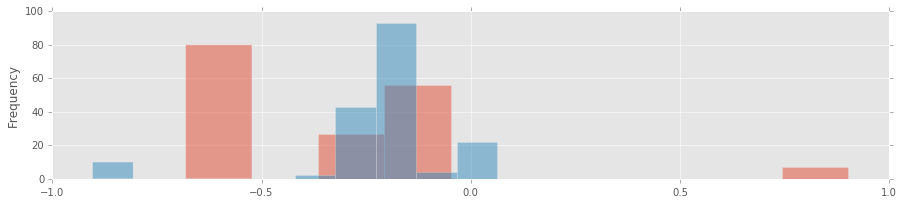

In [39]:
DT.facebookbias_rating[DT.facebookbias_rating < 3].plot.hist(alpha=0.5)
HC.facebookbias_rating[HC.facebookbias_rating < 3].plot.hist(alpha=0.5)

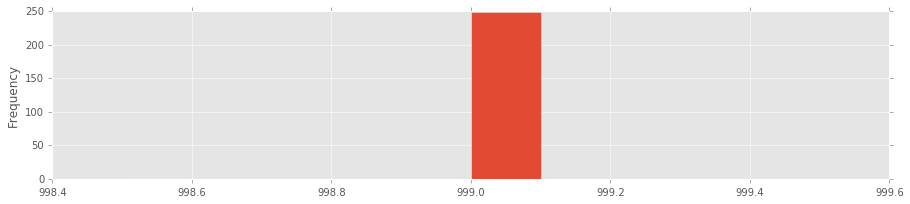

In [27]:
HC.facebookbias_rating[HC.facebookbias_rating > 3].plot.hist()

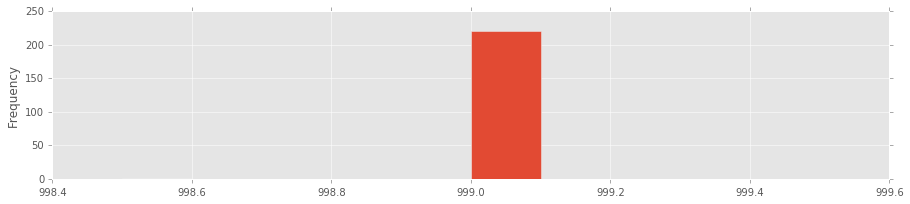

In [28]:
DT.facebookbias_rating[DT.facebookbias_rating > 3].plot.hist()

In [43]:
HC.facebookbias_rating.value_counts()

 999.0000    249
-0.2145       57
-0.2705       43
-0.1334       36
 0.0634       22
-0.9037       10
-0.0585        4
-0.3336        2
Name: facebookbias_rating, dtype: int64

In [44]:
DT.facebookbias_rating.value_counts()

 999.0000    220
-0.6813       80
-0.0585       56
-0.2145       23
-0.2705        4
 0.8898        4
 0.9009        3
Name: facebookbias_rating, dtype: int64